<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/ns_2_module5_hw-BigModel%232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [19]:
from google.colab import drive

DRIVE_MOUNT = './DRIVE/'
DRIVE_MOUNT_SAVE_MODEL_PATH = 'My Drive/Colab Notebooks/'
drive.mount(DRIVE_MOUNT, force_remount=True)

Mounted at ./DRIVE/


In [20]:
!rm -rf input && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/test.zip" -d input \
 && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/train.zip" -d input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/sample-submission.csv" input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/train.csv" input \
 && mv input/test_upload input/test

Archive:  ./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/test.zip
   creating: input/test_upload/
  inflating: input/test_upload/97344.jpg  
  inflating: input/test_upload/48172.jpg  
  inflating: input/test_upload/86074.jpg  
  inflating: input/test_upload/95406.jpg  
  inflating: input/test_upload/52289.jpg  
  inflating: input/test_upload/87970.jpg  
  inflating: input/test_upload/54540.jpg  
  inflating: input/test_upload/3985.jpg  
  inflating: input/test_upload/5212.jpg  
  inflating: input/test_upload/89920.jpg  
  inflating: input/test_upload/298734.jpg  
  inflating: input/test_upload/307551.jpg  
  inflating: input/test_upload/42452.jpg  
  inflating: input/test_upload/29780.jpg  
  inflating: input/test_upload/67521.jpg  
  inflating: input/test_upload/69701.jpg  
  inflating: input/test_upload/35923.jpg  
  inflating: input/test_upload/58281.jpg  
  inflating: input/test_upload/29931.jpg  
  inflating: input/test_upload/38337.jpg  
  inflating: input/test_upload/91663.jpg  
 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os
import tensorflow as tf

from shutil import copyfile

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, LambdaCallback, TensorBoard
from keras.callbacks import Callback
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model
from keras.utils import np_utils
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.layers import *
import keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

INPUT_DIR = 'input/'

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(INPUT_DIR))

# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

!pip show keras

['test', 'train.csv', 'sample-submission.csv', 'train']
Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, pyyaml, keras-preprocessing, keras-applications, six, scipy, h5py
Required-by: 


In [0]:
!rm -rf cat_input

import random
random.seed(42)

DATA_PATH = 'cat_input/'
ORIGIN_DATA_PATH = INPUT_DIR

def copy_by_percent(src_dir, dst_dir, percent):
    for sub_dir in os.listdir(src_dir):
        sub_dir_path = os.path.join(src_dir, sub_dir)
        dst_sub_dir = os.path.join(dst_dir, sub_dir)
        if not os.path.exists(dst_sub_dir):
            os.makedirs(dst_sub_dir)
        for img in os.listdir(sub_dir_path):
            if random.randint(0,100) > percent:
                continue
            src_img_path = os.path.join(sub_dir_path, img)
            copyfile(src_img_path, os.path.join(dst_sub_dir, img))

copy_by_percent('input/train', os.path.join(DATA_PATH, 'train'), 100)

# Setup

In [0]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

BATCH_SIZE           = 32
CLASS_NUM            = 10

IMG_SIZE             = 299
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

PATH = "working/car/"

In [0]:
!rm -rf working/car/
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

from tensorflow import set_random_seed
set_random_seed(RANDOM_SEED)

# EDA / Анализ данных

           Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
Id          15561 non-null object
Category    15561 non-null int64
dtypes: int64(1), object(1)
memory usage: 243.2+ KB
None
1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64
Пример картинок (random sample)


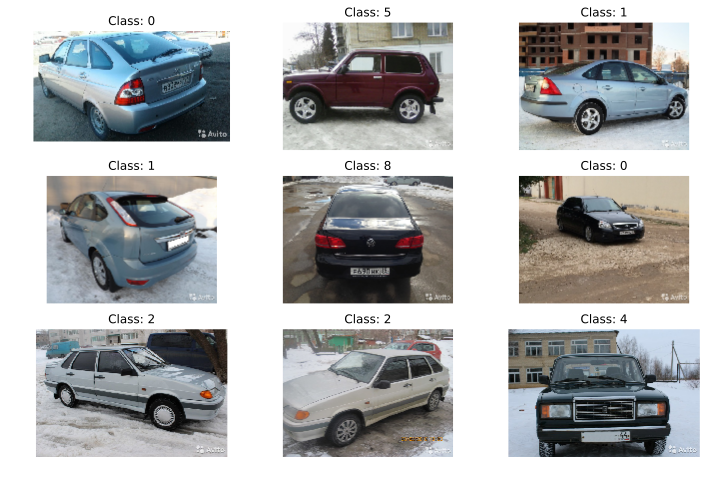

In [25]:
train_df = pd.read_csv(ORIGIN_DATA_PATH+"train.csv")
sample_submission = pd.read_csv(ORIGIN_DATA_PATH+"sample-submission.csv")
print(train_df.head())
print(train_df.info())
print(train_df.Category.value_counts())

print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(ORIGIN_DATA_PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

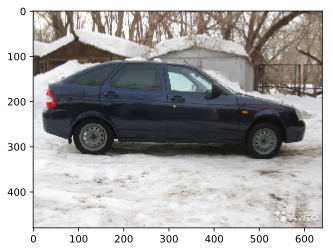

(640, 480)

In [26]:
image = PIL.Image.open(ORIGIN_DATA_PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Data

### Data augmentation

### datagen

In [0]:
# Задание для Про - попробуй подключить сторонние более продвинутые библиотеки аугминтации изображений
from imgaug import augmenters as iaa
import imgaug as ia

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
class Imgaug_Data_Generator():
    def __init__(self, data_generator, imgaug_seq):
        self.data_generator = data_generator
        self.imgaug_seq = imgaug_seq
    
    def __len__(self):
        return len(self.data_generator)
    
    def __iter__(self):
        return self

    def __next__(self):
        data = next(self.data_generator)
        aug_imgs = self.imgaug_seq.augment_images(data[0])
        return (aug_imgs, data[1])

In [28]:
# train_datagen = ImageDataGenerator(validation_split=.1, rescale=1. / 255)

# "Заворачиваем" наши данные в generator

# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
# Поиграйся тут параметрами чтоб понять что к чему. 
# Официальная дока https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1, # set validation split
    channel_shift_range=.5,
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training',
) # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation',
) # set as validation data

# seq = iaa.Sequential([
#     iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     sometimes(
#         iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
#             rotate=(-25, 25), # rotate by -45 to +45 degrees
#             shear=(-8, 8), # shear by -16 to +16 degrees
#             order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#             cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#             mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         ),
#     ),
#     iaa.Sometimes(.5, iaa.Dropout(.02)),
#     iaa.Sometimes(.5, iaa.ChannelShuffle()),
#     # iaa.Sometimes(0.5, iaa.Invert(0.05, per_channel=True)), # invert color channels
#     # iaa.Sometimes(0.5, iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
#     # iaa.Sometimes(0.5, iaa.AddToHueAndSaturation((-20, 20)))
# ])
# train_generator = Imgaug_Data_Generator(train_generator, seq)

plt.figure(figsize=(32,32))
imgs = next(train_generator)
for (i, im) in enumerate(imgs[0]):
    # print(im.shape)
    plt.subplot(8,8, i+1)
    plt.imshow(im)

plt.show()


Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.


In [29]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://4e8e3cec.ngrok.io


# Model

### подгружаем предобученую сеть Xception

In [0]:
# Устанавливаем новую "голову"
# Тут тоже можно поиграться, попробуй добавить Batch Normalization например.
# Кстати Попробуй еще другие архитектуры сетей...

def attach_output_to_model(new_model):
    x = new_model.output

    x = GlobalMaxPooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='elu', kernel_regularizer=l2(), activity_regularizer=l2(),)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(CLASS_NUM, activation='softmax')(x)
    return (new_model, predictions)

def make_new_Xception_model():
    reset_tf_session()
    return Xception(weights='imagenet', include_top=False, input_shape = input_shape)

def make_new_Inception_Resnet_v2_model():
    reset_tf_session()
    return InceptionResNetV2(weights='imagenet', include_top=False, input_shape = input_shape)
    

## Fit

In [0]:
def make_weight_decay_scheduler(w_decay_vatiants, cycle_size):
    steps = len(w_decay_vatiants)
    step_size = round(cycle_size / steps)
    next_change = 0
    step_index = 0
    
    def scheduler(batch, logs):
        nonlocal next_change
        nonlocal step_index
        if next_change > batch or step_index >= steps:
            return
        # print('\nCurrent weight decay:', w_decay_vatiants[step_index])
        K.set_value(model.optimizer.decay, w_decay_vatiants[step_index])
        next_change += step_size
        step_index += 1

    return scheduler

In [0]:
class Model_LR_scheduler():
    def __init__(self, target_lr, cycle_size, split=.9):
        self.target_lr = target_lr
        self.cycle_size = cycle_size
        self.split = split

    def changeTarget(self, new_target):
        self.target_lr = new_target

    def __call__(self):
        def calculate_params():
            phase_1_end = round(self.cycle_size* self.split)
            lr_peak = round(phase_1_end / 2)
            phase_2_start = phase_1_end + 1

            lower_lr = self.target_lr * .1
            phase_2_lower_lr = lower_lr * .1
            lower_lr_step = (self.target_lr - lower_lr) / lr_peak
            phase_2_lower_lr_step = (lower_lr - phase_2_lower_lr) / (self.cycle_size - phase_2_start + 1)

            return (lr_peak, phase_2_start, lower_lr, phase_2_lower_lr, lower_lr_step, phase_2_lower_lr_step)

        def scheduler(batch, logs):
            lr_peak, phase_2_start, lower_lr, phase_2_lower_lr, lower_lr_step, phase_2_lower_lr_step = calculate_params()
            if batch == 0:
                K.set_value(model.optimizer.lr, lower_lr)
            
            new_lr = 0
            if batch < lr_peak:
                new_lr = K.get_value(model.optimizer.lr) + lower_lr_step
                K.set_value(model.optimizer.lr, new_lr)
            elif batch >= lr_peak and batch < phase_2_start:
                new_lr = K.get_value(model.optimizer.lr) - lower_lr_step
                K.set_value(model.optimizer.lr, new_lr)
            else:
                new_lr = K.get_value(model.optimizer.lr) - phase_2_lower_lr_step
                if new_lr < phase_2_lower_lr:
                    new_lr = phase_2_lower_lr
                K.set_value(model.optimizer.lr, new_lr)
            # print('\nCurrent LR:', new_lr)

        return scheduler

In [0]:
from datetime import datetime
now = datetime.now()

# base_model, predictions = attach_output_to_model(make_new_base_model())
base_model, predictions = attach_output_to_model(make_new_Inception_Resnet_v2_model())
# Обучаем
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(), metrics=["accuracy"])

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')

lr_scheduler = Model_LR_scheduler(.01, len(train_generator))
batch_cycle_lr = LambdaCallback(on_batch_end=lr_scheduler())
batch_w_decay = LambdaCallback(on_batch_end=make_weight_decay_scheduler([1e-4,1e-5,1e-6], len(train_generator)))
callbacks_list = [checkpoint, batch_cycle_lr, TensorBoardColabCallback(tbc)]

# Для про - попробуй добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

def save_batch_phase():
    save_dir_path = DRIVE_MOUNT + DRIVE_MOUNT_SAVE_MODEL_PATH + now.strftime("%m_%d_%Y-%H:%M:%S/")
    print('Save dir path:', save_dir_path)
    os.makedirs(save_dir_path)
    def save_model(name, model):
        model.save('working/model_last.hdf5')
        copyfile('working/model_last.hdf5', save_dir_path + name + '_model_last.hdf5')
        copyfile('best_model.hdf5', save_dir_path + name + '_best_model.hdf5')
    return save_model

def load_model_from_save(save_dir, phase_name, model):
    model.load_weights(DRIVE_MOUNT + DRIVE_MOUNT_SAVE_MODEL_PATH + save_dir + phase_name, '_best_model.hdf5')

save_model = save_batch_phase()



def train_phase(epochs, lr, name):
    if lr is not None:
        lr_scheduler.changeTarget(lr)
    
    model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = epochs,
        callbacks = callbacks_list
    )
    save_model(name, model)

def unfreeze_layers(layers):
    # все слои обучаемы
    for layer in model.layers:
        layer.trainable = True
        if isinstance(layer, BatchNormalization):
            # быстрее настраиваем параметры батч норма!
            layer.momentum = 0.9
        
    # fine-tuning только для 50 последних слоев
    for layer in model.layers[:-layers]:
        # батч норм должен настраивать свои параметры для новых данных! а иначе фиксируем слой!
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

# попробуй применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом
unfreeze_layers(10)
train_phase(5, .005, '1')
model.load_weights('best_model.hdf5')
unfreeze_layers(50)
train_phase(6, .002, '2')
model.load_weights('best_model.hdf5')
unfreeze_layers(100)
train_phase(6, .00075, '3')
model.load_weights('best_model.hdf5')
unfreeze_layers(150)
train_phase(6, .0004, '4')
model.load_weights('best_model.hdf5')
unfreeze_layers(200)
train_phase(6, .0001, '5')


Save dir path: ./DRIVE/My Drive/Colab Notebooks/09_09_2019-10:37:20/


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


209/438 [=============>................] - ETA: 9:32 - loss: 9.1353 - acc: 0.5606

In [0]:
model.save('working/model_last.hdf5')

In [0]:
model.load_weights('best_model.hdf5')

In [0]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Submission

In [0]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=ORIGIN_DATA_PATH+'test',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


print(test_sub_generator.samples)

test_sub_generator.reset()

predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Для Про - попробуй TTA

In [0]:
submission.head()

In [0]:
# Для Про - попробуй TTA
import tqdm
test_sub_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=.5,
    horizontal_flip=False,
)
test_sub_generator = test_sub_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=ORIGIN_DATA_PATH+'test',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

tta_steps = 10
pred_list_tta = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator,  steps=len(test_sub_generator), verbose=1)
    pred_list_tta.append(preds)

tta_pred = np.mean(pred_list_tta, axis=0)
tta_pred = np.argmax(tta_pred, axis=-1)
predictions = [label_map[k] for k in tta_pred]

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_tta.csv', index=False)
print('Save submit')

## Интересно, к какому классу модель отнесет вот этот авто:
![](http://kvu.su/upload/iblock/e3a/e3a32ed064fd71e4ce99b7f57d2de745.jpg)